# Zero-shot image tagging using hierse and pytorch

This note shows how to perform zero-shot image tagging using hierse and pytorch (version 0.3.0). 

## 1. Setup hierse

1. Follow the [instruction](https://github.com/li-xirong/hierse#getting-started) to download a pretrained word2vec model.
2. Build label embedding vectors for $Y_0$ (ilsvrc12\_test1k) and $Y_1$ (ilsvrc12\_test1k_2hop).
```
python build_label_vec.py ilsvrc12_test1k
python build_label_vec.py ilsvrc12_test1k_2hop
```
3. Initialize instances for image embedding (`Image2Vec`), label embedding (`Synset2Vec`) and zero-shot image tagging (`ZeroShotTagger`).

In [1]:
import sys
sys.path.append('..')
from synset2vec import Synset2Vec
from im2vec import Image2Vec
from tagger import ZeroshotTagger

i2v = Image2Vec()
s2v = Synset2Vec()
tagger = ZeroshotTagger()

[23 Dec 22:36:07 - bigfile.py:line 24] 1000x500 instances loaded from /Users/xirong/VisualSearch/synset2vec/ilsvrc12_test1k/flickr4m,tagvec500,hierse2
[23 Dec 22:36:07 - im2vec.py:line 44] #active_labels=1000, embedding_size=500
[23 Dec 22:36:07 - bigfile.py:line 24] 382298x500 instances loaded from /Users/xirong/VisualSearch/flickr4m/word2vec/tagvec500
[23 Dec 22:36:07 - synset2vec.py:line 27] w2v(flickr4m): 382298 words, 500 dims
[23 Dec 22:36:07 - bigfile.py:line 24] 1548x500 instances loaded from /Users/xirong/VisualSearch/synset2vec/ilsvrc12_test1k_2hop/flickr4m,tagvec500,hierse2
[23 Dec 22:36:07 - tagger.py:line 43] #active_labels=1548, embedding_size=500


Load the label set $Y_0$:

In [2]:
labels = map(str.strip, open('../data/synsets_ilsvrc12_test1k.txt').readlines())

## 2. Load a pretrained CNN model

In [3]:
from PIL import Image
import os
import numpy as np
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable

In [4]:
#model = models.alexnet(pretrained=True)
model = models.resnet18(pretrained=True)
#model = models.resnet50(pretrained=True)
model.eval() # set it to the test mode

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

## 3. Define a preprocess function for input images

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])

## 4. Perform zero-shot tagging for a single image

Read a specific image using the PIL lib.

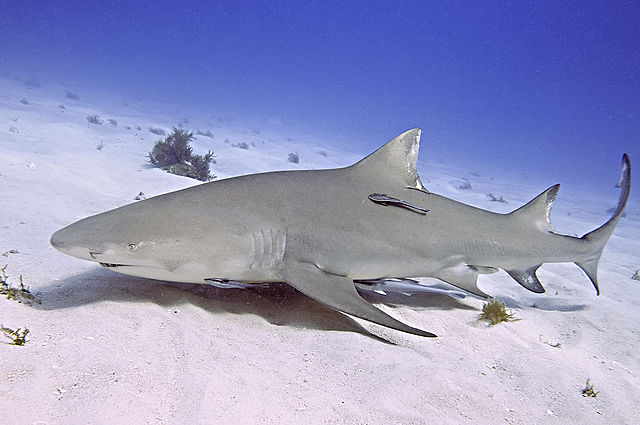

In [6]:
img_fname = 'lemon_shark.jpg'
img_pil = Image.open(img_fname).convert('RGB')
img_pil

Now, predict $Y_0$ using the pretrained model.

In [7]:
img_tensor = preprocess(img_pil)
img_tensor.unsqueeze_(0)
img_var = Variable(img_tensor)
result = model(img_var)

softmax_layer = nn.Softmax()
probs = softmax_layer(result)
probs = probs.data.cpu().numpy()
probs = probs[0]
sorted_inds = [i[0] for i in sorted(enumerate(-probs), key=lambda x:x[1])]
for i in range(5):
    index = sorted_inds[i]
    print('Probability %0.2f%% => %s [%s]' % (probs[index] * 100, labels[index], s2v.explain(labels[index])))

Probability 84.61% => n01491361 [tiger shark, Galeocerdo cuvieri]
Probability 5.76% => n01494475 [hammerhead, hammerhead shark]
Probability 2.97% => n01484850 [great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias]
Probability 1.41% => n04552348 [warplane, military plane]
Probability 1.29% => n01498041 [stingray]


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Predict $Y_1$ using hierse

In [8]:
img_vec = i2v.embedding(probs)
res = tagger.predict(img_vec, topk=5)
print ([(label, s2v.explain(label), score) for (label,score) in res])

for i in range(5):
    label,score = res[i]
    print('Probability %0.2f%% => %s [%s]' % (score * 100, label, s2v.explain(label)))

[('n01488918', 'requiem shark', 0.91833145035306041), ('n01482330', 'shark', 0.91627126710308848), ('n01495006', 'shovelhead, bonnethead, bonnet shark, Sphyrna tiburo', 0.8758341533220142), ('n01483522', 'mackerel shark', 0.8728679673239691), ('n01494757', 'smooth hammerhead, Sphyrna zygaena', 0.75616815469323562)]
Probability 91.83% => n01488918 [requiem shark]
Probability 91.63% => n01482330 [shark]
Probability 87.58% => n01495006 [shovelhead, bonnethead, bonnet shark, Sphyrna tiburo]
Probability 87.29% => n01483522 [mackerel shark]
Probability 75.62% => n01494757 [smooth hammerhead, Sphyrna zygaena]


## 5. Perform zero-shot tagging for a set of images

The following code shows how to perform zero-shot image tagging for the sample set `imagenet2hop-random2k`. First, download the image data:
```
cd $HOME/VisualSearch
wget data/sigir2015/imagenet2hop-random2k-images.tar
tar xf imagenet2hop-random2k-images.tar
```

Read image-ids of `imagenet2hop-random2k`:

In [9]:
rootpath = os.path.join(os.environ['HOME'], 'VisualSearch')
collection = 'imagenet2hop-random2k'
imset_fname = os.path.join(rootpath, collection, 'ImageSets', '%s.txt' % collection)
imset = map(str.strip, open(imset_fname).readlines())
print ('nr of test images: %d' % len(imset))

nr of test images: 2000


In [12]:
def predict_y0(model, img_fname):
    img_pil = Image.open(img_fname).convert('RGB')
    img_tensor = preprocess(img_pil)
    img_tensor.unsqueeze_(0)
    img_var = Variable(img_tensor)
    result = model(img_var)

    softmax_layer = nn.Softmax()
    probs = softmax_layer(result)
    probs = probs.data.cpu().numpy()
    probs = probs[0]
    return probs


import random
random.seed(42)
random.shuffle(imset)

Ns = [1, 2, 5, 10]
hitN = [0] * len(Ns)  
nr_metrics = len(Ns)

for progress,imageid in enumerate(imset):
    true_label = imageid.split('_',1)[0]
    img_fname = os.path.join(rootpath, collection, 'ImageData', '%s.jpg' % imageid)
    score_y0 = predict_y0(model, img_fname)
    img_vec = i2v.embedding(score_y0)
    res = tagger.predict(img_vec, topk=10)
    
    for i in range(nr_metrics):
        top = Ns[i]
        pred_set = set([x[0] for x in res[:top]])
        hitN[i] += (true_label in pred_set)
        
    if (progress+1)%100 == 0:
        print (progress+1), 'images tagged ->', ' '.join(['%.1f' % (100.0*float(x)/(progress+1)) for x in hitN]) 
        
hitN = [float(x)/len(imset) for x in hitN]
print ' '.join(['hit%d' % x for x in Ns])
print ' '.join(['%.1f' % (x*100) for x in hitN])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


100 images tagged -> 15.0 25.0 34.0 52.0
200 images tagged -> 16.5 28.5 40.0 55.0
300 images tagged -> 19.3 30.3 41.3 55.7
400 images tagged -> 18.5 29.5 43.5 57.5
500 images tagged -> 19.0 29.6 43.8 57.0
600 images tagged -> 19.3 29.3 44.3 57.8
700 images tagged -> 19.1 29.3 44.9 58.1
800 images tagged -> 18.8 28.5 44.2 58.4
900 images tagged -> 20.1 30.6 46.2 59.8
1000 images tagged -> 19.5 30.1 46.6 60.3
1100 images tagged -> 19.5 30.3 46.6 60.2
1200 images tagged -> 19.6 30.6 47.0 60.8
1300 images tagged -> 19.8 31.5 47.8 61.2
1400 images tagged -> 19.9 31.5 48.1 61.2
1500 images tagged -> 20.1 31.3 48.3 61.2
1600 images tagged -> 19.9 31.0 47.8 60.9
1700 images tagged -> 19.8 30.9 47.6 60.5
1800 images tagged -> 19.7 30.6 47.3 60.3
1900 images tagged -> 19.7 30.7 47.6 60.5
2000 images tagged -> 19.9 30.9 47.7 60.5
hit1 hit2 hit5 hit10
19.9 30.9 47.7 60.5
